In [295]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import matplotlib.tri as mtri
%matplotlib inline

In [321]:
class RectangleMesh():
    def __init__(self, point_1, point_2, nx, ny):
        self.num_nodes = (nx+1)*(ny+1)
        self.num_ele = (nx)*(ny)
        self.geomtery = self.create_geometry(point_1, point_2, nx, ny)
        self.topology = self.create_topology(nx,ny)
    
    def create_geometry(self, point_1, point_2, nx, ny):
        """ This method will return the node_number vs
        co-ordinate table. The node numbering is done left
        to right, bottom to top.
        """
        geo = np.zeros((self.num_nodes,2))
        x = np.linspace(point_1[0],point_2[0],nx+1)
        y = np.linspace(point_1[1],point_2[1],ny+1)
        xx, yy = np.meshgrid(x, y)
        geo[:,0] = xx.reshape(self.num_nodes) 
        geo[:,1] = yy.reshape(self.num_nodes)
        return geo
    def create_topology(self, nx, ny):
        """
        This method will create the connectivity table.
        The element number is done left to right, bottom to top.
        """
        topo = np.zeros((self.num_ele, 4)).astype(int)
        for i in range(ny):
            for j in range(nx):
                ele_num = nx*(i)+j
                topo[ele_num,:] = [ele_num+i,ele_num+i+1,ele_num+i+nx+2,ele_num+i+nx+1]
        return topo
    def plot(self):
        for i in range(self.num_ele):
            p = Polygon(self.geomtery[np.ix_(self.topology[i])], fc='white',ec="black",lw=3)
            plt.gca().add_patch(p)
        plt.axis('scaled')
        plt.show()


In [322]:
mesh = RectangleMesh([0, 0], [1, 1], 5, 5)

In [323]:
mesh.geomtery[np.ix_(mesh.topology[0])]

array([[0. , 0. ],
       [0.2, 0. ],
       [0.2, 0.2],
       [0. , 0.2]])

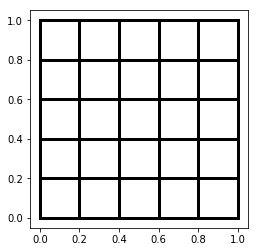

In [324]:
mesh.plot()

In [325]:
def basis(xi,eta):
    """This function will return the basis value and its derivatives at a point (xi, eta)."""
    N = [1/4*(1-xi)*(1-eta),1/4*(1+xi)*(1-eta),1/4*(1+xi)*(1+eta),1/4*(1-xi)*(1+eta)]
    dN_dxi = [-1/4*(1-eta), +1/4*(1-eta), +1/4*(1+eta), -1/4*(1+eta)]
    dN_deta = [-1/4*(1-xi) ,-1/4*(1+xi) ,+1/4*(1+xi) ,+1/4*(1-xi)]
    return np.array(N), dN_dxi,dN_deta

In [326]:
def jacobian(xi, eta, ele_num, mesh):
    """This function will create the jacobian matrix and its determinant at point (xi, eta)."""
    x = mesh.geomtery[np.ix_(mesh.topology[ele_num])][:,0]
    y = mesh.geomtery[np.ix_(mesh.topology[ele_num])][:,1]
    N, dN_dxi, dN_deta = basis(xi,eta)

    gp_x = np.dot(N, x)
    gp_y = np.dot(N, y)

    dxdxi = np.zeros((2, 2))
    dxdxi[0, 0] = np.dot(dN_dxi, x)
    dxdxi[0, 1] = np.dot(dN_dxi, y)
    dxdxi[1, 0] = np.dot(dN_deta, x)
    dxdxi[1, 1] = np.dot(dN_deta, y)

    jac_det = dxdxi[0, 0] * dxdxi[1, 1] - dxdxi[0, 1] * dxdxi[1, 0]

    shape_der_para = np.stack([dN_dxi, dN_deta], axis=1)
    jac_inv = np.linalg.inv(dxdxi)
    # here we are converting the derivatives from parametric space to cartesian space
    dN_dX = np.matmul(shape_der_para, jac_inv)
    return N, dN_dX[:,0], dN_dX[:,1], jac_det, gp_x, gp_y

In [327]:
jacobian(-1, 1, 1, mesh)


(array([0., 0., 0., 1.]),
 array([ 0.,  0.,  5., -5.]),
 array([-5.,  0.,  0.,  5.]),
 0.010000000000000002,
 0.2,
 0.2)

In [328]:
def assemble(mesh, load_expression=lambda x, y: 4 * (-y**2+y)* np.sin(np.pi * x)):
    gp = [-np.sqrt(1 / 3),+ np.sqrt(1 / 3)]
    global_stiffness = np.zeros((mesh.num_nodes, mesh.num_nodes))
    global_load = np.zeros(mesh.num_nodes)
    for ele_num in range(0, mesh.num_ele):
        element_load = np.zeros(4)
        element_stiffness = np.zeros((4, 4))
        for eta in gp:
            for xi in gp:
                N, dN_dx, dN_dy, jac_det, gp_x, gp_y = jacobian(xi, eta, ele_num, mesh)

                # Here is the actual definition of poisson's equation.==>(u,x v,x+u,y v,y)
                # w_u,w_v=1,ele_area=4
                element_stiffness = element_stiffness + (
                        np.tensordot(dN_dx, dN_dx, 0) +
                        np.tensordot(dN_dy, dN_dy, 0)) * jac_det * 4
                element_load = element_load + N * load_expression(gp_x, gp_y) * jac_det * 4
        # Once the element level stiffness matrix has been made the next step is to place the elements at
        # their respective position in the global stiffness matrix.
        ele_topo = mesh.topology[ele_num]
        global_stiffness[np.ix_(ele_topo, ele_topo)] = global_stiffness[np.ix_(ele_topo, ele_topo)] + element_stiffness
        global_load[ele_topo] = global_load[ele_topo] + element_load

    return global_stiffness, global_load

In [329]:
assemble(mesh)

(array([[ 2.66666667, -0.66666667,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [-0.66666667,  5.33333333, -0.66666667, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        , -0.66666667,  5.33333333, ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  5.33333333,
         -0.66666667,  0.        ],
        [ 0.        ,  0.        ,  0.        , ..., -0.66666667,
          5.33333333, -0.66666667],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         -0.66666667,  2.66666667]]),
 array([0.00196703, 0.01092026, 0.01766935, 0.01766935, 0.01092026,
        0.00196703, 0.01005369, 0.05581465, 0.09031   , 0.09031   ,
        0.05581465, 0.01005369, 0.01529909, 0.08493534, 0.13742827,
        0.13742827, 0.08493534, 0.01529909, 0.01529909, 0.08493534,
        0.13742827, 0.13742827, 0.08493534, 0.01529909, 0.01005369,
        0.05581465, 0.09031   , 0

In [330]:
def quad2tri(mesh):
    tri_topo = np.zeros((mesh.num_ele*2,3)).astype(int)
    for i in range(mesh.num_ele):
        tri_topo[2*i,:] = mesh.topology[i, np.ix_([0,1,3])]
        tri_topo[2*i+1,:] = mesh.topology[i, np.ix_([1,2,3])]
    return tri_topo

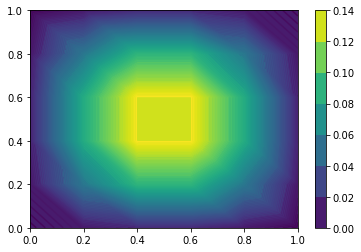

In [335]:
triangles = quad2tri(mesh)
triang = mtri.Triangulation(mesh.geomtery[:,0], mesh.geomtery[:,1], triangles)
fig, axs = plt.subplots()
z=assemble(mesh)[1]
t = axs.tricontourf(triang, z)
axs.tricontour(triang, z, 100)
fig.colorbar(t)
plt.show()

In [311]:
z

array([ 1.        , -1.26940799,  0.42359737, -1.66211751,  0.20903977,
        0.20971862,  0.98311677, -1.11482459,  0.27367058,  0.2729265 ])

In [294]:
from dolfin import *

# Create mesh and define function space
mesh = UnitSquareMesh(2, 2)
V = FunctionSpace(mesh, "Lagrange", 1)

# Define Dirichlet boundary (x = 0 or x = 1)
boundary = CompiledSubDomain("on_boundary")

# Define boundary condition
u0 = Constant(0.0)
bc = DirichletBC(V, u0, boundary)

# Define variational problem
u = TrialFunction(V)
v = TestFunction(V)
f = Expression(" 4 * (-x[1]*x[1]+x[1])* sin(pi * x[0])",degree = 2)
a = inner(grad(u), grad(v))*dx
L = f*v*dx

# Compute solution
u = Function(V)
solve(a == L, u, bc)

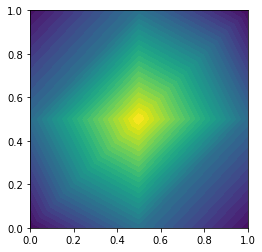

In [281]:
plot(project(f,V))

In [282]:
force = project(f,V)

In [283]:
force.vector()[:]

array([-0.10606602,  0.30533009,  0.33106602, -0.1232233 ,  1.15961941,
       -0.1232233 ,  0.33106602,  0.30533009, -0.10606602])